# Sample Notebook 3 for Picasso
This notebook shows how to perform DBSCAN clustering with picasso.


## Load the localizations

In [1]:
import os.path as ospath
import numpy as np
import matplotlib.pyplot as plt
from picasso import io, clusterer, postprocess
path = 'data/raw_movie_locs.hdf5'
locs, info = io.load_locs(path)

print(f'Loaded {len(locs)} locs.')

Loaded 2399 locs.


# DBSCAN implementation in Picasso
Use the help command to inspect Picasso functions - (almost) all functions are well documenented! You can see the parameters the function takes in and the output you can expect.

In [2]:
help(clusterer.dbscan)

Help on function dbscan in module picasso.clusterer:

dbscan(locs: 'pd.DataFrame', radius: 'float', min_samples: 'int', min_locs: 'int' = 10, pixelsize: 'int | None' = None) -> 'pd.DataFrame'
    Perform DBSCAN on localizations.
    
    See Ester, et al. Inkdd, 1996. (Vol. 96, No. 34, pp. 226-231).
    
    Parameters
    ---------
    locs : pd.DataFrame
        Localizations to be clustered.
    radius : float
        DBSCAN search radius, often referred to as "epsilon". Same units
        as locs.
    min_samples : int
        Number of localizations within radius to consider a given point
        a core sample.
    min_locs : int, optional
        Minimum number of localizations in a cluster. Clusters with
        fewer localizations will be removed. Default is 0.
    pixelsize : int, optional
        Camera pixel size in nm. Only needed for 3D.
    
    Returns
    -------
    locs : pd.DataFrame
        Clusterered localizations, with column 'group' added, which
        specifie

In [3]:
eps = 5 / 130 # from nm to camera pixels
min_samples = 4
clustered_locs = clusterer.dbscan(locs, eps, min_samples)

We can also extract the cluster centers in the format of localizations.

In [4]:
# save cluster centers too
centers = clusterer.find_cluster_centers(clustered_locs)

# Save

In [5]:
base, ext = ospath.splitext(path)
dbscan_info = {
    "Generated by": "Picasso DBSCAN",
    "Min samples": min_samples,
    "Radius (cam. pixels)": eps,
}
info.append(dbscan_info)
io.save_locs(path.replace(".hdf5", "_dbscan.hdf5"), clustered_locs, info)
io.save_locs(path.replace(".hdf5", "_dbscan_centers.hdf5"), centers, info)
print('Complete')

Complete


## Another useful clustering algorithm is SMLM clusterer (used in RESI)
See https://doi.org/10.1038/s41467-021-22606-1 and https://doi.org/10.1038/s41586-023-05925-9.

In [6]:
help(clusterer.cluster)

Help on function cluster in module picasso.clusterer:

cluster(locs: 'pd.DataFrame', radius_xy: 'float', min_locs: 'int', frame_analysis: 'bool', radius_z: 'float | None' = None, pixelsize: 'float | None' = None) -> 'pd.DataFrame'
    Cluster localizations from single molecules (SMLM clusterer).
    
    The general workflow is as follows:
    1. Build a KDTree from the points in X.
    2. For each point, find its neighbors within the given radius.
    3. Identify local maxima, i.e., points with the most neighbors
       within their neighborhood.
    4. Assign cluster labels to all points. If two local maxima are
       within the radius from each other, combine such clusters.
    
    Based on the algorithm published by Schichthaerle et al.
    Nature Comm, 2021 (10.1038/s41467-021-22606-1) and first implemented
    in Reinhardt, Masullo, Baudrexel, Steen, et al. Nature, 2023
    (10.1038/s41586-023-05925-9).
    
    The recommended parameters are ``radius`` of 2*NeNA and ``min_locs

In [7]:
_, nena = postprocess.nena(locs, info)
radius_xy = 2 * nena
min_locs = 10
frame_analysis = False  # useful for rejecting sticking events, see below
clustered_locs = clusterer.cluster(locs, radius_xy, min_locs, frame_analysis)
centers = clusterer.find_cluster_centers(clustered_locs)
new_info = {
    "Generated by": "Picasso SMLM clusterer",
    "Min locs": min_locs,
    "Radius (cam. pixels)": radius_xy,
}
info.append(dbscan_info)
io.save_locs(path.replace(".hdf5", "_clustered.hdf5"), clustered_locs, info)
io.save_locs(path.replace(".hdf5", "_clustered_centers.hdf5"), centers, info)
print('Complete')

Complete


## Frame analysis
Sticking events can happen, for example, due to the fluorophore sticking to a non-specific structures in the sample. This results in a series of localizations that are detected in a row. Therefore, these can be filtered out by rejecting the clusters whose st. dev. of frame is low.

Note: here, we use synthetic data without sticking simulated, thus in real data the st. dev. frame histogram will likely look different.

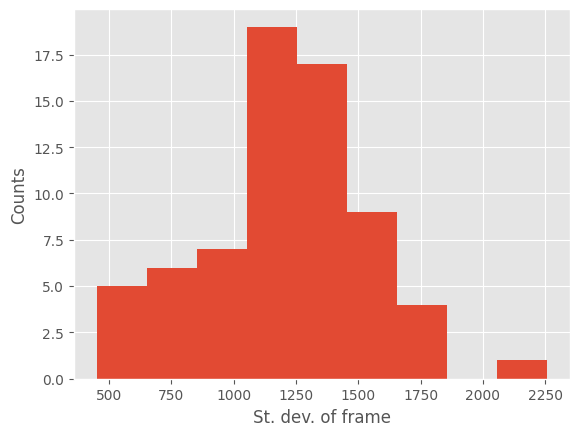

In [8]:
# cluster centers saves the st. dev. frame columns
std_frame = centers["std_frame"]
plt.hist(std_frame, bins="auto")
plt.xlabel("St. dev. of frame")
plt.ylabel("Counts")
plt.show()

In [9]:
# let's set the threshold to 1000 frames
std_frame_min = 1000
mask = std_frame > std_frame_min
centers_filter = centers[mask]

# we can also remove the clustered localizations based on the group column
valid_groups = centers_filter["group"]
clustered_locs_filter = clustered_locs[np.isin(clustered_locs["group"], valid_groups)]

# save both clustered localizations and cluster centers
new_info = {
    "Generated by": "St. dev. frame filter",
    "Threshold": std_frame_min,
}
info.append(dbscan_info)
io.save_locs(path.replace(".hdf5", "_clustered_filter.hdf5"), clustered_locs_filter, info)
io.save_locs(path.replace(".hdf5", "_clustered_centers_filter.hdf5"), centers_filter, info)
print('Complete')

Complete
